# ASF on demand to MintPy
- read folder and unzipped files from ASF on demand (hyp3)
- cut common area
- set up MintPy config file
- run MintPy
- plot velocity
- plot time series (doesn't work)

**load library and functions**

In [6]:
from pathlib import Path
from typing import List, Union
from osgeo import gdal


def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

**read folder and files**

In [7]:
project_name = 'safe_files'
work_dir = Path.cwd() / project_name
data_dir = work_dir 

files = data_dir.glob('*/*_dem.tif')

overlap = get_common_overlap(files)

**define function**

In [3]:
from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

**cut the overlapping areas**

In [4]:
clip_hyp3_products_to_common_overlap(data_dir, overlap)

**set up MintPy configure file**

In [5]:
mintpy_config = work_dir / 'mintpy_config.txt'
mintpy_config.write_text(
f"""
mintpy.load.processor        = hyp3
##---------interferogram datasets
mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif
mintpy.troposphericDelay.method = no
""")

688

**run SBAS mintpy**

In [6]:
!smallbaselineApp.py --dir {work_dir} {mintpy_config}


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.5.3, 2023-11-23
___________________________________________________________

--RUN-at-2024-03-08 08:54:25.399349--
Current directory: C:\Users\leej1\subsidence
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point', 'quick_overview', 'corr

**plot the SBAS result**

In [8]:
#%matplotlib widget
from collections.abc import Mapping
from mintpy.cli import view, tsview

**-velocity**

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: C:\Users\leej1\subsidence\safe_files\velocity.h5 in float32 format
file size in y/x: (2857, 3609)
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (5):
['velocity', 'velocityStd', 'intercept', 'interceptStd', 'residue']
data   coverage in y/x: (0, 0, 3609, 2857)
subset coverage in y/x: (0, 0, 3609, 2857)
data   coverage in lat/lon: (119240.0, 3928280.0, 407960.0, 3699720.0)
subset coverage in lat/lon: (119240.0, 3928280.0, 407960.0, 3699720.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 5
row     number: 2
column  number: 3
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ...
[==================================================] residueptStd    0s /     0

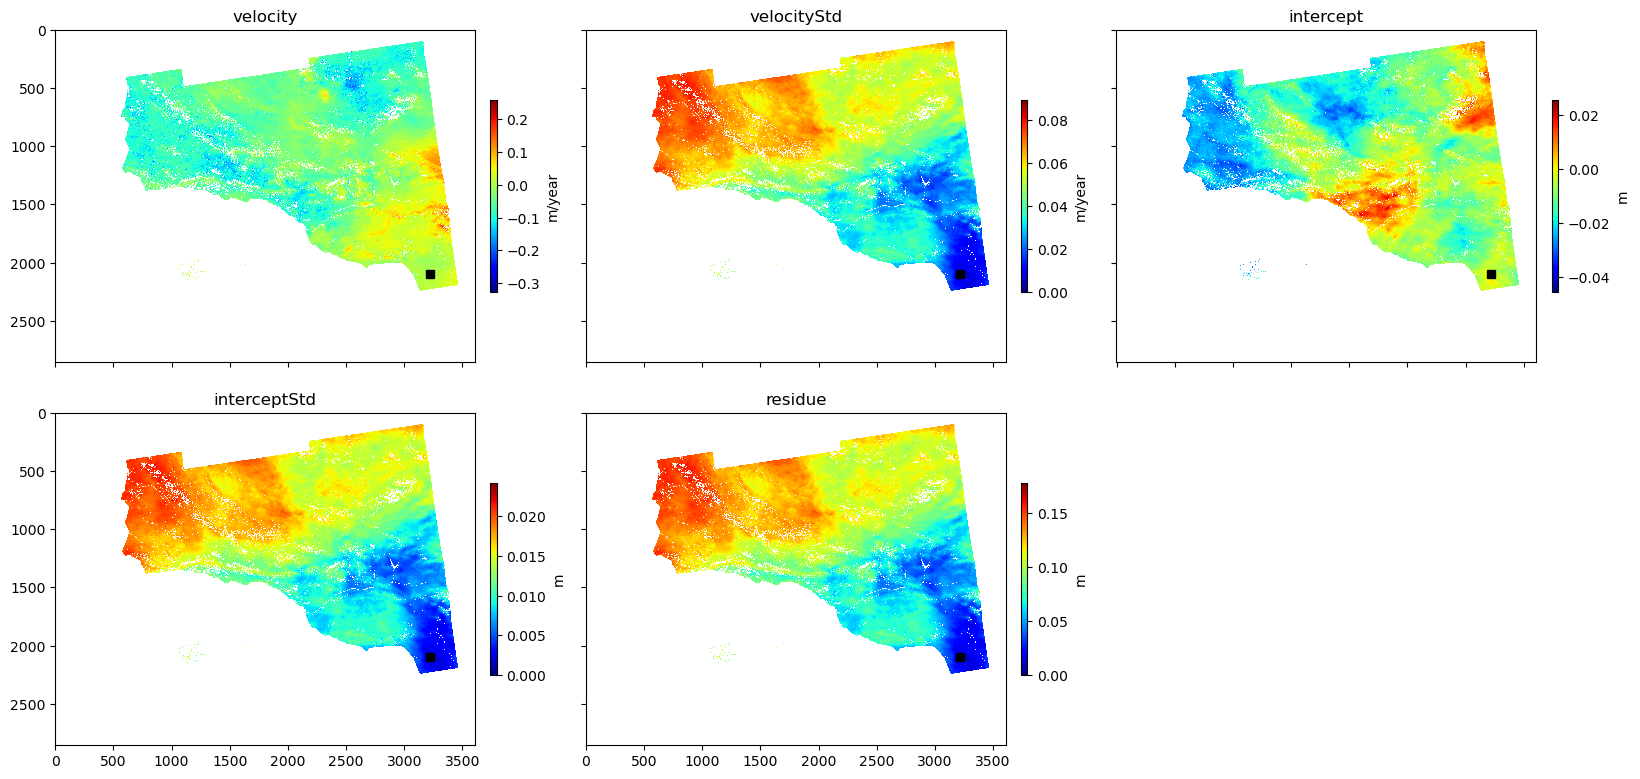

In [9]:
view.main([f'{work_dir}/velocity.h5'])

**time series (doesn't work)**

tsview.py C:\Users\leej1\subsidence\safe_files/timeseries.h5
open timeseries file: timeseries.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 3609, 2857)
subset coverage in y/x: (0, 0, 3609, 2857)
data   coverage in lat/lon: (119240.0, 3928280.0, 407960.0, 3699720.0)
subset coverage in lat/lon: (119240.0, 3928280.0, 407960.0, 3699720.0)
------------------------------------------------------------------------
total number of pixels: 1.5E+08
* multilook 2 by 2 with nearest interpolation for display to save memory
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file C:\Users\leej1\subsidence\safe_files/timeseries.h5 with step of 2 by 2
reading 2D slices 15/15...
reference to date: 20230125
read mask from file: maskTempCoh.h5
data    range: [-18.937986, 13.947682] cm
display range: [-

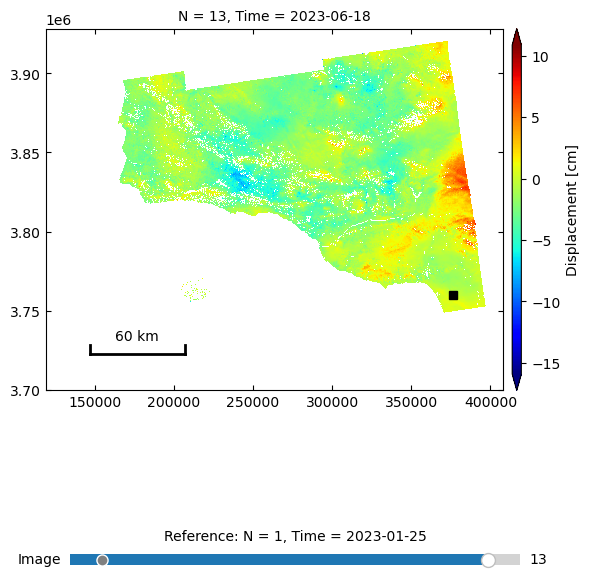

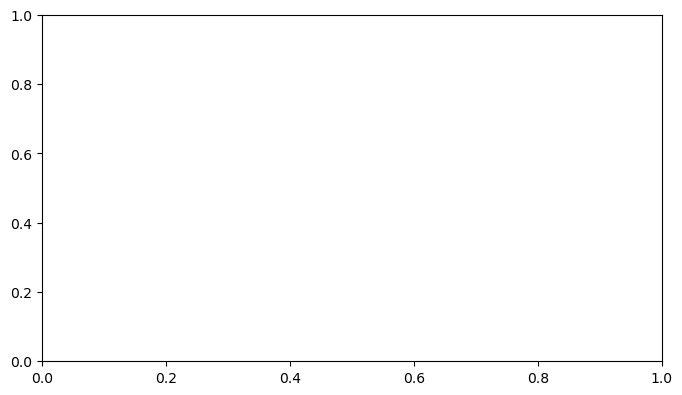

In [10]:
tsview.main([f'{work_dir}/timeseries.h5'])